In [71]:
import yaml
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.stats import wstat
from gammapy.spectrum import SpectrumFit, CrabSpectrum
from gammapy.spectrum.models import SpectralModel

import corner

from tqdm import tqdm
import emcee

from scipy.optimize import minimize
from gammapy.spectrum import CountsPredictor
# np.seterr(all='raise')
# from astropy.utils.exceptions import AstropyWarning
# import warnings
# warnings.filterwarnings('error', category=AstropyWarning, append=True)
from utils import load_spectrum_observations, Log10Parabola
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [60]:
tels = ['fact', 'magic', 'fermi', 'hess', 'veritas']

Having poisson signals and poisson bkg calls for the combined likelihood which looks like this:

$$
    L (n_{\mathrm{on}}, n_{\mathrm{off}}, \alpha; \mu_{\mathrm{sig}},
    \mu_{\mathrm{bkg}}) = \frac{(\mu_{\mathrm{sig}}+\alpha
    \mu_{\mathrm{bkg}})^{n_{\mathrm{on}}}}{n_{\mathrm{on}} !}
    \exp{(-(\mu_{\mathrm{sig}}+\alpha \mu_{\mathrm{bkg}}))}\times
    \frac{(\mu_{\mathrm{bkg}})^{n_{\mathrm{off}}}}{n_{\mathrm{off}}
    !}\exp{(-\mu_{\mathrm{bkg}})},
$$

Taking the logarithm yields. 

$$
  \ln L \left(n_{\mathrm{on}}, n_{\mathrm{off}}, \alpha; \mu_{\mathrm{sig}}, \mu_{\mathrm{bkg}}\right) 
  = n_{\mathrm{on}} \ln(\mu_{\mathrm{sig}} + \alpha \mu_{\mathrm{bkg}}) + n_{\mathrm{off}} \ln(\mu_{\mathrm{bkg}})
  - \mu_{\mathrm{sig}} - (\alpha + 1)\mu_{\mathrm{bkg}}
$$

Since we have no model for the background we have to treat the $mu_{bkg}$ as nuisance parameters. This would create another free parameter per energy bin. So we rather look at the profile likelihood.

By analytically maximizing the likelihood with respect to $mu_{\mathrm{bkg}}$ we can create a profile likelihood.
Setting the derivative of the likelihood equals to 0 we get
$$
\frac{\partial \ln L}{\partial \mu_{\mathrm{bkg}}} \stackrel{!}{=}  0
$$

which after some transformations leads to 

$$
\mu_{\mathrm{bkg}} = \left(\alpha(n_{on} + n_{off}) + (\alpha + 1) \mu_{\mathrm{sig}}\right) + \frac{1}{2\alpha(\alpha + 1)} \sqrt{ \left(\alpha(n_{on} + n_{off}) + (\alpha + 1) \mu_{\mathrm{sig}}\right)^2 - 4\alpha(\alpha + 1)}
$$


In [61]:
def model_signal_prediction(model, observation):
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
    counts *= observation.on_vector.areascal
    return counts.value

def ln_profile_likelihood(mu_sig, n_on, n_off, alpha):
    c = alpha * (n_on + n_off) - (alpha + 1)*mu_sig
    k = alpha * (alpha + 1)
    d = np.sqrt(c**2 + 4*k*mu_sig*n_off)
    mu_bkg = np.nan_to_num((c+d)/(2*k))
    with np.errstate(divide='ignore', invalid='ignore'):
        ll = n_on * np.log(mu_sig + alpha * mu_bkg)  - mu_sig - (alpha+1) * mu_bkg
        likelihood_value = np.where(mu_bkg == 0, ll, ll + n_off * np.log(mu_bkg))
    
    return np.where((mu_sig == 0) & (n_on == 0) & (n_off == 0), 0, -likelihood_value)
    

def ln_prior(theta):
    '''
    Uninformative poisson prior as far as I know. 
    
    See https://en.wikipedia.org/wiki/Jeffreys_prior
    '''
    mu_sig = theta
    prior = np.ones_like(mu_sig)

#     m = mu_sig > 0
#     prior[m] = np.sqrt(1/(mu_sig[m]))
    
    m = mu_sig < 0
    prior[m] = -np.inf
    return np.log(prior)



def ln_prob(theta, n_on, n_off, alpha, return_posterior=False):
    
    prob = 0.5*ln_profile_likelihood(theta, n_on, n_off, alpha)

    if return_posterior:
        lp = ln_prior(theta)
#         print(f'Mu: {theta}')
#         print(f'prior: {lp}')
        prob = prob + lp
    
    return np.where(np.isfinite(prob), prob, 0)


def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]


def model_probability(theta, observations, return_posterior=False, fit_range=None):
    amplitude, alpha, beta = theta
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
       
    obs_probabilities = []
    for obs in observations:
        mu_sig = model_signal_prediction(model, obs)
        n_on=obs.on_vector.data.data.value
        n_off=obs.off_vector.data.data.value
        obs_alpha=obs.alpha

        if fit_range is not None:
            bins = obs.on_vector.energy.bins
            mu_sig, n_on, n_off, obs_alpha = apply_range(mu_sig, n_on, n_off, obs_alpha, bins=bins, fit_range=fit_range)

        prob = ln_prob(mu_sig, n_on, n_off, obs_alpha, return_posterior=return_posterior).sum()            
        obs_probabilities.append(prob)
    return -sum(obs_probabilities)
    

In [62]:
obs_list = load_spectrum_observations('magic')
fit_range = [0.08, 30] * u.TeV

In [63]:
# obs = obs_list[0]
# obs.on_vector.energy.bins.to('TeV')
# # obs.hi_threshold.to('TeV')
# idx = np.searchsorted(obs.on_vector.energy.bins.to(u.TeV), fit_range.to(u.TeV) )
# obs.on_vector.energy.bins[idx[0]: idx[1]].to('TeV')
model_probability([4, 2, 0.5], obs_list, return_posterior=False, fit_range=None)

4095.6807249335916

In [65]:
N = 25
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

zs = []
zs_post = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    zs.append(model_probability([4, alpha, beta], obs_list))
#     print(model_probability([3.8, alpha, beta], obs_list, return_posterior=True))
    zs_post.append(model_probability([4, alpha, beta], obs_list, return_posterior=False, fit_range=fit_range))

zs = np.array(zs)
zs_post = np.array(zs_post)


625it [00:08, 70.04it/s]


Text(0, 0.5, 'beta')

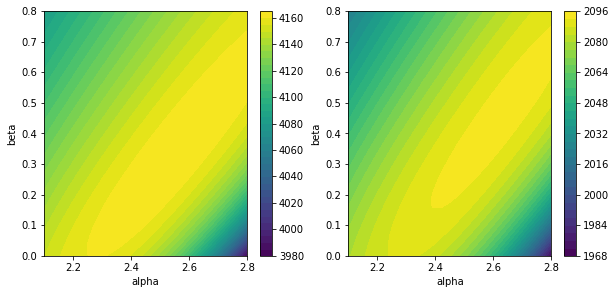

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

cf = ax1.contourf(a, b, zs.reshape(len(a), -1), levels=40)
# ax1.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

cf = ax2.contourf(a, b, zs_post.reshape(len(a), -1), levels=40 )
plt.colorbar(cf, ax=ax2)
# ax2.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')


In [67]:
obs_list = load_spectrum_observations('joint')
fit_range = [0.08, 30] * u.TeV

result = minimize(lambda *x: -model_probability(*x), x0= [3.8, 2.6, 0.4], args=(obs_list, True, fit_range))
result

      fun: -13239.483233510338
 hess_inv: array([[ 0.00068168,  0.00107105, -0.00038937],
       [ 0.00107105,  0.00191128, -0.00084023],
       [-0.00038937, -0.00084023,  0.00045087]])
      jac: array([0.        , 0.00024414, 0.00024414])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 116
      nit: 13
     njev: 23
   status: 2
  success: False
        x: array([4.06824705, 2.52552737, 0.31966708])

In [68]:
ndim, nwalkers = 3, 50
pos = np.array([result.x + 0.1 * np.random.randn(ndim) for i in range(nwalkers)])
# print(pos)
sampler = emcee.EnsembleSampler(nwalkers, ndim, model_probability, args=(obs_list, True), threads=2)
sampler_output = sampler.run_mcmc(pos, 150, progress=True)

100%|██████████| 150/150 [03:06<00:00,  1.06s/it]


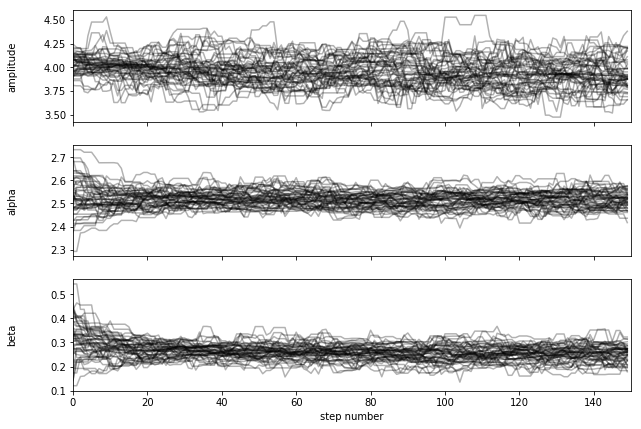

In [69]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["amplitude", "alpha", "beta"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, len(sampler.chain[0]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


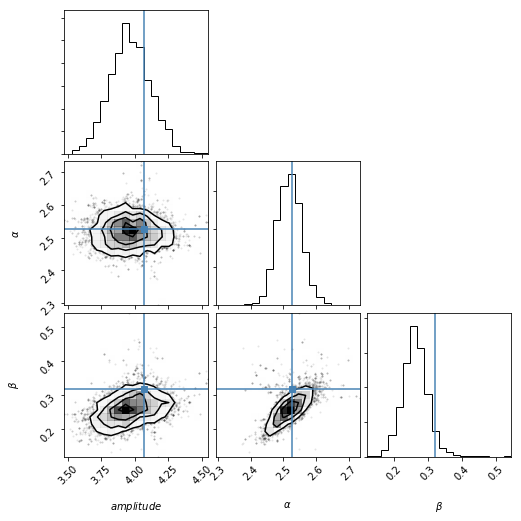

In [72]:
fig = corner.corner(sampler.chain.reshape(-1, ndim), labels=["$amplitude$", "$\\alpha$", "$\\beta$"], truths=result.x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[3.93333866 2.51740051 0.25698614]


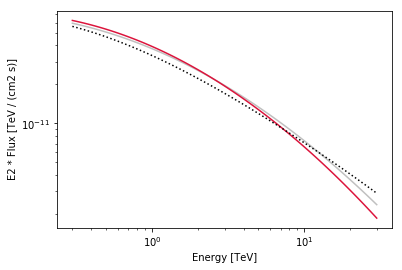

In [73]:
from IPython.display import display, Math

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, 50:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
joint_model = Log10Parabola(
    amplitude=3.78 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.49 * u.Unit(''),
    beta=0.22 * u.Unit(''),
)
joint_model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='silver')

r = np.median(sampler.chain[:, 50:, :3], axis=(0, 1))
print(r)
fitted_model = Log10Parabola(
    amplitude=r[0] * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=r[1] * u.Unit(''),
    beta=r[2] * u.Unit(''),
)
fitted_model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='crimson')

CrabSpectrum(reference='meyer').model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='black', ls=':')